## Low Light Images

In [1]:
import os
from collections import defaultdict
from sklearn.model_selection import train_test_split

def load_images_with_labels_from_directory(directory):
    # Initialize a list for storing image paths and their labels
    images_with_labels = []
    # Define acceptable image extensions in lowercase
    valid_extensions = {'.png', '.jpg', '.jpeg'}
    # Dictionary to store class counts
    class_counts = defaultdict(int)
    
    # Walk through each directory and its subdirectories
    for root, _, files in os.walk(directory):
        for file in files:
            # Extract file extension
            _, ext = os.path.splitext(file)
            # Check if the extension is valid
            if ext.lower() in valid_extensions:
                # Derive class label from the folder name
                class_label = os.path.basename(root)
                # Append the full path of the image and its class label
                images_with_labels.append((os.path.join(root, file), class_label))
                # Update the class count
                class_counts[class_label] += 1
    
    # Print total number of images for each class
    print("Image count per class:")
    for class_label, count in class_counts.items():
        print(f"{class_label}: {count}")
    
    return images_with_labels

# Directory path for the low-light dataset
dataset_directory = '/kaggle/input/codandata/data/test_night'  

# Load images with labels
all_images_with_labels = load_images_with_labels_from_directory(dataset_directory)

# Perform train-test split (80%-20%) on the images with labels
train_images, test_images = train_test_split(all_images_with_labels, test_size=0.2, random_state=42)

# Print number of images in each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")

Image count per class:
Motorbike: 250
Bus: 250
Dog: 250
Cup: 250
Car: 250
Boat: 250
Bicycle: 250
Chair: 250
Cat: 250
Bottle: 250
Number of training images: 2000
Number of testing images: 500


In [3]:
type(train_images), type(train_images[0])

(list, tuple)

In [4]:
train_images[0]

('/kaggle/input/codandata/data/test_night/Cat/2015_03750.png', 'Cat')

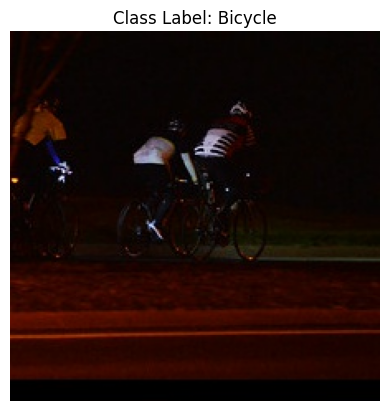

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Select a random image from the training set
random_image_path, label = random.choice(train_images)

# Load and plot the image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Class Label: {label}")
plt.axis('off')  
plt.show()

## Normal Light Images

In [2]:
import os
from collections import defaultdict

# Function to load images from a given directory, associating each image with its class label
def load_images_with_labels_from_directory(directory):

    images_with_labels = []
    valid_extensions = {'.png', '.jpg', '.jpeg'}
    class_counts = defaultdict(int)
    
    for root, _, files in os.walk(directory):
        for file in files:
            _, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions:
                class_label = os.path.basename(root)
                images_with_labels.append((os.path.join(root, file), class_label))
                class_counts[class_label] += 1
    
    print(f"Loaded images from {directory}")
    for class_label, count in class_counts.items():
        print(f"{class_label}: {count}")
    
    return images_with_labels

# Paths for normal-light training directories
train_dir1 = '/kaggle/input/codandata/data/train'  
train_dir2 = '/kaggle/input/codandata/data/val'  

# Load and combine training images from both directories
nlight_train_images = load_images_with_labels_from_directory(train_dir1) + \
                      load_images_with_labels_from_directory(train_dir2)

print(f"Total training images: {len(nlight_train_images)}")

# Path for normal-light test directory
test_dir = '/kaggle/input/codandata/data/test_day'  

# Load test images
nlight_test_images = load_images_with_labels_from_directory(test_dir)

print(f"Total testing images: {len(nlight_test_images)}")

Loaded images from /kaggle/input/codandata/data/train
Motorbike: 1000
Bus: 1000
Dog: 1000
Cup: 1000
Car: 1000
Boat: 1000
Bicycle: 1000
Chair: 1000
Cat: 1000
Bottle: 1000
Loaded images from /kaggle/input/codandata/data/val
Motorbike: 50
Bus: 50
Dog: 50
Cup: 50
Car: 50
Boat: 50
Bicycle: 50
Chair: 50
Cat: 50
Bottle: 50
Total training images: 10500
Loaded images from /kaggle/input/codandata/data/test_day
Motorbike: 250
Bus: 250
Dog: 250
Cup: 250
Car: 250
Boat: 250
Bicycle: 250
Chair: 250
Cat: 250
Bottle: 250
Total testing images: 2500


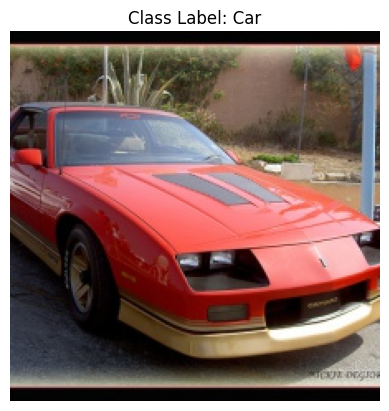

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Select a random image from the training set
random_image_path, label = random.choice(nlight_train_images)

# Load and plot the image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Class Label: {label}")
plt.axis('off')  
plt.show()

In [12]:
img.shape

(224, 224, 3)

## Finetune Resnet-18

In [ ]:
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim

# Step 1: Define a custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, images_with_labels, label_to_int, transform=None):
        """
        Args:
            images_with_labels: list of tuples, each containing (image_path, class_label).
            label_to_int: dict mapping class label (str) to integer label.
            transform: torchvision.transforms to apply.
        """
        self.images_with_labels = images_with_labels
        self.label_to_int = label_to_int
        self.transform = transform

    def __len__(self):
        return len(self.images_with_labels)

    def __getitem__(self, idx):
        img_path, class_label = self.images_with_labels[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels
        label = self.label_to_int[class_label]  # Convert label to integer

        if self.transform:
            image = self.transform(image)

        return image, label

# Step 2: Create a dictionary to map class labels to integers
unique_labels = sorted(list(set([label for _, label in train_images])))
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_to_label = {idx: label for label, idx in label_to_int.items()}  

# Step 3: Define transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Step 4: Create Dataset and DataLoader instances
train_dataset = CustomImageDataset(train_images, label_to_int, transform=train_transform)
val_dataset = CustomImageDataset(test_images, label_to_int, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Step 5: Load ResNet-18 with pretrained weights and modify for 10-class classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  
model = model.to(device)

# Step 6: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Step 7: Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_model(model, "best_model.pth")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Step 8: Functions to save and load model weights
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    print(f"Model loaded from {path}")

#Step 9: Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)

## Pseudo-Label Generation

/tmp/ipykernel_30/565073340.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Model loaded from /kaggle/input/weights-saccce/best_model (3).pth
Original Image - Predicted Label: Bicycle, Confidence: 1.0000


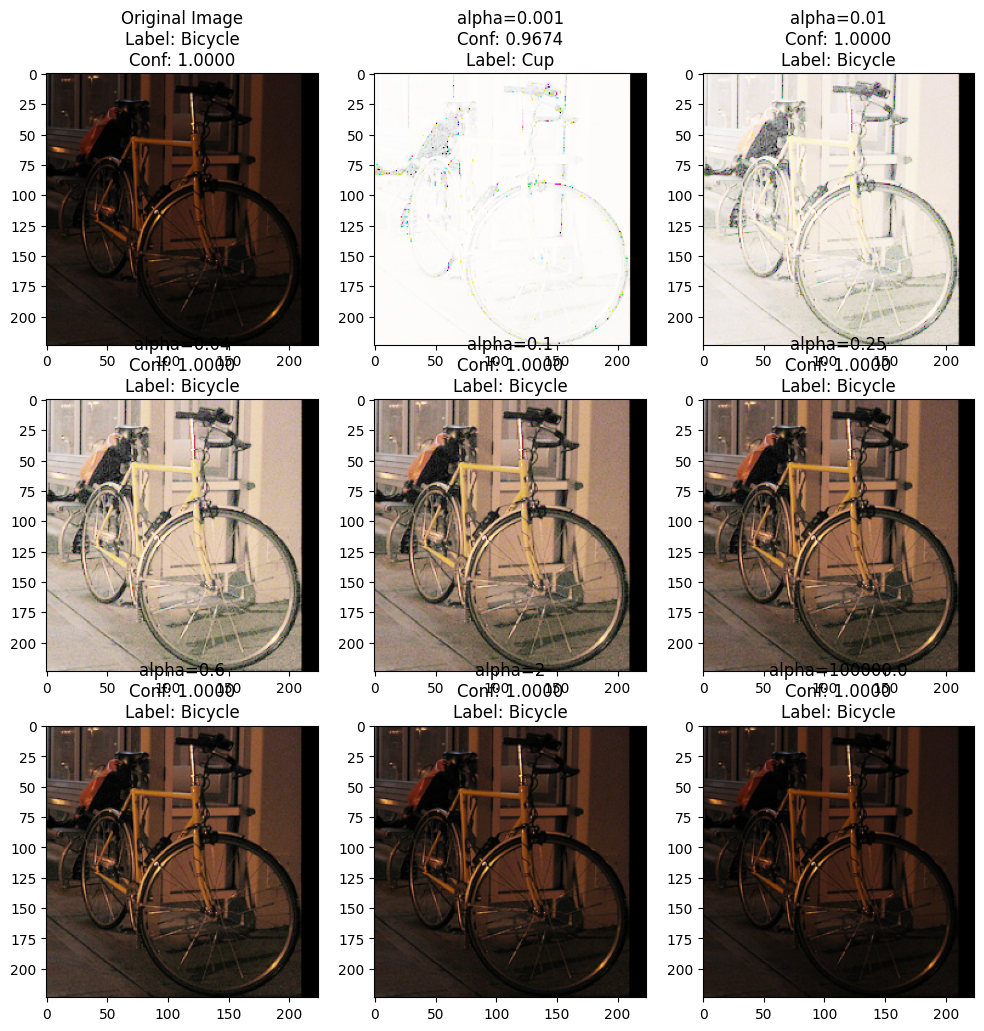

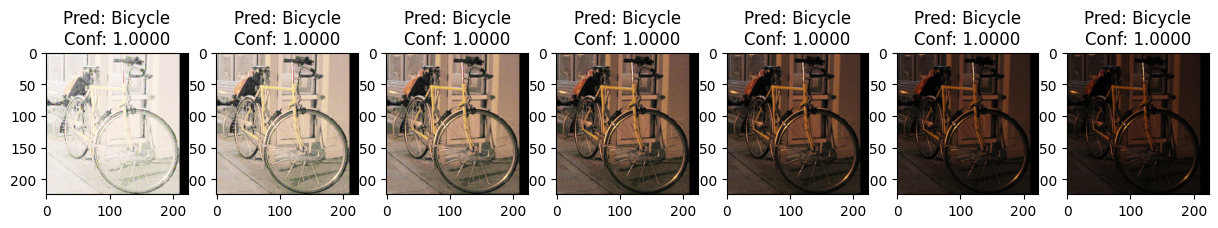

In [4]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-18 model for inference
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # Adjusted final layer for 10 classes
model = model.to(device)

# Load model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    print(f"Model loaded from {path}")

# path to model weights file
model_weights_path = "/kaggle/input/weights-saccce/best_model (3).pth"
load_model(model, model_weights_path)
model.eval()
# Define class labels
int_to_label = {
    0: 'Bicycle', 1: 'Boat', 2: 'Bottle', 3: 'Bus', 4: 'Car',
    5: 'Cat', 6: 'Chair', 7: 'Cup', 8: 'Dog', 9: 'Motorbike'
}

# Define enhancement curves
curve_params = [0.001, 0.01, 0.04, 0.1, 0.25, 0.6, 2, 1e5]

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Threshold values
t1 = 1 - 1e-5
t2 = 2

# Function to apply enhancement curve
def apply_curve_enhancement(image, alpha):
    """
    Apply curve enhancement on the input image with parameter alpha.
    """
    np_img = np.array(image) / 255.0  # Normalize image to [0, 1]
    enhanced_img = ((alpha + 1) * np_img) / (np_img + alpha)
    enhanced_img = np.clip(enhanced_img * 255, 0, 255).astype(np.uint8)  # Scale back to [0, 255]
    return Image.fromarray(enhanced_img)

# Load and preprocess an image
image_path = '/kaggle/input/codandata/data/test_night/Bicycle/2015_00003.png'  # Update this path
original_image = Image.open(image_path).convert("RGB").resize((224, 224))

# Step 1: Predict class and confidence for the original image
input_tensor = transform(original_image).unsqueeze(0).to(device)  # Add batch dimension
with torch.no_grad():
    output = model(input_tensor)
    prob = F.softmax(output, dim=1)
    original_confidence, original_predicted_label = torch.max(prob, 1)
    original_confidence = original_confidence.item()
    original_predicted_label = int_to_label[original_predicted_label.item()]

print(f"Original Image - Predicted Label: {original_predicted_label}, Confidence: {original_confidence:.4f}")

# Step 2: Generate and plot all enhanced images
enhanced_images = []
confidences_per_image = []  # To store confidence scores
predicted_labels_per_image = []  # To store predicted labels

for alpha in curve_params:
    enhanced_image = apply_curve_enhancement(original_image, alpha)
    enhanced_images.append(enhanced_image)

    # Perform inference on enhanced image
    input_tensor = transform(enhanced_image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)
        prob = F.softmax(output, dim=1)
        confidence, predicted_label = torch.max(prob, 1)
        confidence = confidence.item()
        predicted_label = predicted_label.item()
        
        # Store confidence and predicted label
        confidences_per_image.append(confidence)
        predicted_labels_per_image.append(int_to_label[predicted_label])

# Plot original and enhanced images with confidence scores
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.imshow(original_image)
plt.title(f"Original Image\nLabel: {original_predicted_label}\nConf: {original_confidence:.4f}")
for i, (img, conf, label) in enumerate(zip(enhanced_images, confidences_per_image, predicted_labels_per_image)):
    plt.subplot(3, 3, i + 2)
    plt.imshow(img)
    plt.title(f"alpha={curve_params[i]}\nConf: {conf:.4f}\nLabel: {label}")
plt.show()

# Step 3: Filter and plot images that pass thresholding
selected_images = []
selected_labels = []
selected_confidences = []

for img, conf, label in zip(enhanced_images, confidences_per_image, predicted_labels_per_image):
    if conf >= t1:
        selected_images.append(img)
        selected_labels.append(label)
        selected_confidences.append(conf)

# Plot images that remain after thresholding with predicted labels and confidence scores
plt.figure(figsize=(15, 8))
for i, (img, conf, label) in enumerate(zip(selected_images, selected_confidences, selected_labels)):
    plt.subplot(1, len(selected_images), i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {label}\nConf: {conf:.4f}")
plt.show()

In [15]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pretrained ResNet-18 model for inference
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # Adjust final layer for 10 classes
model = model.to(device)

# Load model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    print(f"Model loaded from {path}")

model_weights_path = "/kaggle/input/weights-srcc-lr0-01/best_model (2).pth"
load_model(model, model_weights_path)
model.eval()
# Define class labels
int_to_label = {
    0: 'Bicycle', 1: 'Boat', 2: 'Bottle', 3: 'Bus', 4: 'Car',
    5: 'Cat', 6: 'Chair', 7: 'Cup', 8: 'Dog', 9: 'Motorbike'
}

label_to_int = {v: k for k, v in int_to_label.items()}

# Define enhancement curves
curve_params = [0.001, 0.01, 0.04, 0.1, 0.25, 0.6, 2, 1e5]

def apply_curve_enhancement(image, alpha):
    """
    Apply curve enhancement on the input image with parameter alpha.
    """
    np_img = np.array(image) / 255.0  # Normalize image to [0, 1]
    enhanced_img = ((alpha + 1) * np_img) / (np_img + alpha)
    enhanced_img = np.clip(enhanced_img * 255, 0, 255).astype(np.uint8)  # Scale back to [0, 255]
    return Image.fromarray(enhanced_img)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Define thresholds
t1 = 0.99
t2 = 2

# Initialize list to store pseudo-labeled images
pseudo_train_images = []

# Iterate over each image in the low-light training dataset
for img_path, true_label_str in train_images:
    true_label_int = label_to_int[true_label_str]
    predictions = []
    confidences = []

    # Load and prepare the original image
    original_image = Image.open(img_path).convert("RGB").resize((224, 224))

    # Enhance the image with each curve in the ensemble
    for alpha in curve_params:
        enhanced_image = apply_curve_enhancement(original_image, alpha)
        input_tensor = transform(enhanced_image).unsqueeze(0).to(device)  # Add batch dimension

        # Get model prediction
        with torch.no_grad():
            output = model(input_tensor)
            prob = F.softmax(output, dim=1)
            confidence, predicted_label = torch.max(prob, 1)
            confidence = confidence.item()
            predicted_label = predicted_label.item()

            # Store predictions and confidences above t1
            if confidence >= t1:
                predictions.append(predicted_label)
                confidences.append(confidence)

    # Check if there are at least t2 predictions with consensus on the label
    if len(predictions) >= t2:
        # Get the most common prediction among the high-confidence predictions
        most_common_prediction = max(set(predictions), key=predictions.count)

        # Ensure the number of agreements meets threshold t2
        if predictions.count(most_common_prediction) >= t2:
            pseudo_train_images.append((img_path, int_to_label[most_common_prediction]))

# Calculate accuracy of pseudo-labels
correct_count = 0
total_count = 0

for img_path, pseudo_label in pseudo_train_images:
    # Find the original label for comparison
    original_label = next((label for path, label in train_images if path == img_path), None)
    
    if original_label is not None:
        total_count += 1
        if pseudo_label == original_label:
            correct_count += 1

pseudo_label_accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
print(f"Pseudo-Label Accuracy: {pseudo_label_accuracy:.2f}%")
print(f"Total Pseudo-Labelled Images: {len(pseudo_train_images)} out of {len(train_images)}")

/tmp/ipykernel_30/3956608890.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Model loaded from /kaggle/input/weights-srcc-lr0-01/best_model (2).pth
Pseudo-Label Accuracy: 94.71%
Total Pseudo-Labelled Images: 548 out of 2000


In [16]:
combined_train = pseudo_train_images + nlight_train_images
combined_test = test_images + nlight_test_images
len(combined_train), len(combined_test)

(11048, 3000)

## Model

In [ ]:
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Step 1: Define a custom Dataset class with image enhancement
class CustomEnhancedImageDataset(Dataset):
    def __init__(self, images_with_labels, label_to_int, transform=None, alpha=0.6):
        """
        Args:
            images_with_labels: list of tuples, each containing (image_path, class_label).
            label_to_int: dict mapping class label (str) to integer label.
            transform: torchvision.transforms to apply.
            alpha: float, enhancement parameter for low-light images.
        """
        self.images_with_labels = images_with_labels
        self.label_to_int = label_to_int
        self.transform = transform
        self.alpha = alpha

    def apply_curve_enhancement(self, image):
        """
        Apply curve enhancement on the input image with the given alpha parameter.
        """
        np_img = np.array(image) / 255.0  # Normalize image to [0, 1]
        enhanced_img = ((self.alpha + 1) * np_img) / (np_img + self.alpha)
        enhanced_img = np.clip(enhanced_img * 255, 0, 255).astype(np.uint8)  # Scale back to [0, 255]
        return Image.fromarray(enhanced_img)

    def __len__(self):
        return len(self.images_with_labels)

    def __getitem__(self, idx):
        img_path, class_label = self.images_with_labels[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels
        image = image.resize((224, 224))  # Resize to 224x224
        image = self.apply_curve_enhancement(image)  # Apply enhancement
        label = self.label_to_int[class_label]  # Convert label to integer

        if self.transform:
            image = self.transform(image)

        return image, label

# Step 2: Create a dictionary to map class labels to integers
unique_labels = sorted(list(set([label for _, label in combined_train])))
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_to_label = {idx: label for label, idx in label_to_int.items()}  
print(int_to_label)

# Step 3: Define transformations with rotation augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Step 4: Create Dataset and DataLoader instances using enhanced images
train_dataset = CustomEnhancedImageDataset(combined_train, label_to_int, transform=train_transform, alpha=0.6)
val_dataset = CustomEnhancedImageDataset(combined_test, label_to_int, transform=val_transform, alpha=0.6)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Step 5: Load ResNet-18 with pretrained weights and modify for 10-class classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  
model = model.to(device)

# Step 6: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Step 7: Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_model(model, "best_model.pth")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Step 8: Functions to save and load model weights
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    print(f"Model loaded from {path}")

model_weights_path = "/kaggle/input/weights-srcc-lr0-01/best_model (2).pth"
load_model(model, model_weights_path)

# Step 9: Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)

/tmp/ipykernel_30/2307962365.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded from /kaggle/input/weights-saccce/best_model (3).pth


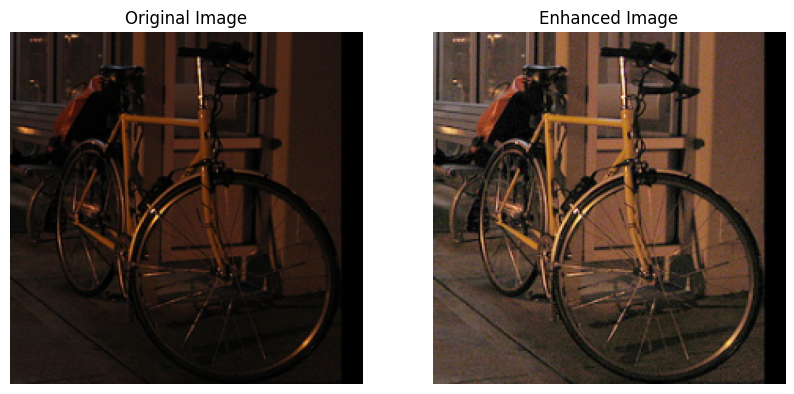

Predicted Label for /kaggle/input/codandata/data/test_night/Bicycle/2015_00003.png: Bicycle (Confidence: 1.0000)


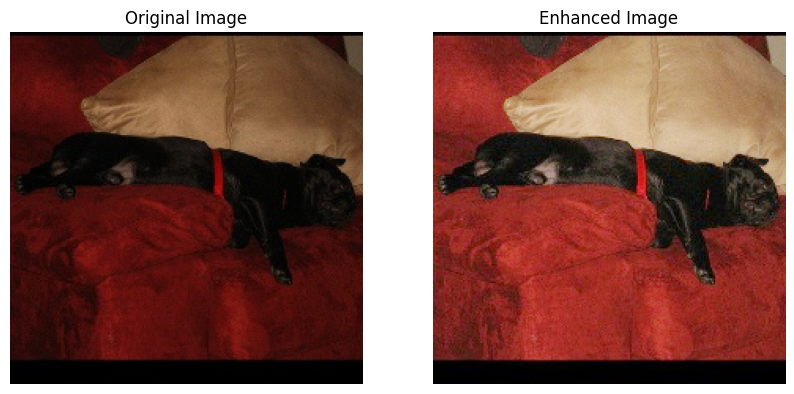

Predicted Label for /kaggle/input/codandata/data/test_night/Dog/2015_04947.jpg: Dog (Confidence: 0.9898)


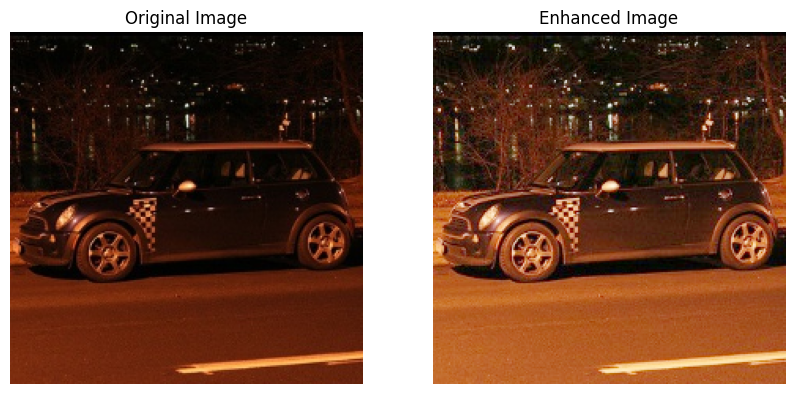

Predicted Label for /kaggle/input/codandata/data/test_night/Car/2015_02408.jpg: Car (Confidence: 1.0000)


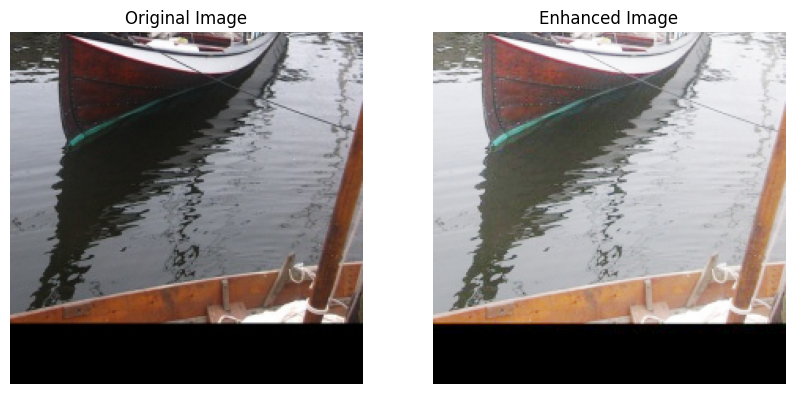

Predicted Label for /kaggle/input/codandata/data/test_day/Boat/000000002290.jpg: Boat (Confidence: 1.0000)


In [12]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained ResNet-18 model for inference
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # Adjust final layer for 10 classes
model = model.to(device)

# Load model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"Model loaded from {path}")

# Specify the path to the model weights
model_weights_path = "/kaggle/input/weights-saccce/best_model (3).pth"  # Update this path
load_model(model, model_weights_path)

# Define class labels (assuming these are the labels as in your previous code)
int_to_label = {
    0: 'Bicycle', 1: 'Boat', 2: 'Bottle', 3: 'Bus', 4: 'Car',
    5: 'Cat', 6: 'Chair', 7: 'Cup', 8: 'Dog', 9: 'Motorbike'
}

# Define enhancement parameter
alpha = 0.6

# Define transformation (matching the normalization used in training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Define enhancement function
def apply_curve_enhancement(image, alpha):
    """
    Apply curve enhancement on the input image with parameter alpha.
    """
    np_img = np.array(image) / 255.0  # Normalize image to [0, 1]
    enhanced_img = ((alpha + 1) * np_img) / (np_img + alpha)
    enhanced_img = np.clip(enhanced_img * 255, 0, 255).astype(np.uint8)  # Scale back to [0, 255]
    return Image.fromarray(enhanced_img)

# Input list of low-light image paths
lowlight_image_paths = ['/kaggle/input/codandata/data/test_night/Bicycle/2015_00003.png', 
                        '/kaggle/input/codandata/data/test_night/Dog/2015_04947.jpg', 
                        '/kaggle/input/codandata/data/test_night/Car/2015_02408.jpg', 
                        '/kaggle/input/codandata/data/test_day/Boat/000000002290.jpg']

# Iterate over each image, enhance, plot, and predict
for img_path in lowlight_image_paths:
    # Load and prepare the original image
    original_image = Image.open(img_path).convert("RGB").resize((224, 224))
    
    # Apply enhancement with alpha = 0.6
    enhanced_image = apply_curve_enhancement(original_image, alpha = 0.4)
    
    # Plot the original and enhanced images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].axis('off')
    axes[0].set_title("Original Image")
    
    axes[1].imshow(enhanced_image)
    axes[1].axis('off')
    axes[1].set_title("Enhanced Image")
    plt.show()
    
    # Transform the enhanced image for model input
    input_tensor = transform(enhanced_image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)
        prob = F.softmax(output, dim=1)
        confidence, predicted_label = torch.max(prob, 1)
        confidence = confidence.item()
        predicted_label = predicted_label.item()
        class_label = int_to_label[predicted_label]
    
    # Print predicted class label and confidence
    print(f"Predicted Label for {img_path}: {class_label} (Confidence: {confidence:.4f})")

In [17]:
import torch
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels
int_to_label = {
    0: 'Bicycle', 1: 'Boat', 2: 'Bottle', 3: 'Bus', 4: 'Car',
    5: 'Cat', 6: 'Chair', 7: 'Cup', 8: 'Dog', 9: 'Motorbike'
}
label_to_int = {v: k for k, v in int_to_label.items()}

# Load the trained model
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  
model = model.to(device)

# Load the trained model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    print(f"Model loaded from {path}")

model_weights_path = "/kaggle/input/weights-saccce/best_model (3).pth"
load_model(model, model_weights_path)
model.eval()

# Define the enhancement function with alpha = 0.6
def apply_curve_enhancement(image, alpha=0.6):
    np_img = np.array(image) / 255.0  # Normalize image to [0, 1]
    enhanced_img = ((alpha + 1) * np_img) / (np_img + alpha)
    enhanced_img = np.clip(enhanced_img * 255, 0, 255).astype(np.uint8)  # Scale back to [0, 255]
    return Image.fromarray(enhanced_img)

# Define transformations for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over each image in the combined_test set
for img_path, true_label_str in combined_test:
    true_label = label_to_int[true_label_str]
    
    # Load and enhance the image
    image = Image.open(img_path).convert("RGB").resize((224, 224))
    enhanced_image = apply_curve_enhancement(image, alpha=0.6)
    input_tensor = test_transform(enhanced_image).unsqueeze(0).to(device)  # Add batch dimension

    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_label = torch.max(output, 1)
        predicted_label = predicted_label.item()

    # Append true and predicted labels for evaluation
    y_true.append(true_label)
    y_pred.append(predicted_label)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

/tmp/ipykernel_30/386134870.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Model loaded from /kaggle/input/weights-saccce/best_model (3).pth
Accuracy: 92.37%
Precision: 0.9239
Recall: 0.9237
F1-Score: 0.9237
